# Santander Value Prediction Challenge
The aim of this challenge is to predict the "value of transactions for each potential customer" based on customer data provided by the Santander Bank. More specifically, the bank wants us to predict the "value of the customer's transaction" before it occurs. provided with an anonymized dataset containing numeric feature variables, the numeric target column, and a string `ID` column.

In [0]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import spearmanr
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb




import warnings
warnings.filterwarnings('ignore')

## Data Overview


In [2]:
train_df = pd.read_csv("/content/train.csv.zip")
test_df = pd.read_csv("/content/test.csv.zip")
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

Train rows and columns :  (4459, 4993)
Test rows and columns :  (49342, 4992)


In [3]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,...,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


### Training set

The train data set has 4459 rows and 49,342 rows in test set. We also have 4,993 columns in total including the target and id column.
- Don't have meaningful names for the features. So, we have to rely on other ways to analyze and understand the data.
- Test set is almost 10 times as that of train set. 
- Number of columns is more than the number of train rows. So need to be careful with feature selection / engineering.
- Have an anonymised `ID` feature together with a numerical target variable. 
- Anonymized column names. 
- Large numerical range of values.
- There are many zero values present in the data.

In [4]:
def rstr(df): return df.info(), df.apply(lambda x: [x.unique()])
print(rstr(train_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB
(None, ID           [[000d6aaf2, 000fbd867, 0027d6b71, 0028cbf45, ...
target       [[38000000.0, 600000.0, 10000000.0, 2000000.0,...
48df886f9    [[0.0, 280000.0, 600000.0, 200000.0, 110000.0,...
0deb4b6a8               [[0, 6000, 4000000, 1196000, 1000000]]
34b15f335    [[0.0, 18400000.0, 3738666.66, 160000.0, 34120...
                                   ...                        
71b203550    [[0, 72000000, 800000, 14600000, 1116000, 4400...
137efaa80    [[0, 40000, 3420000, 10000000, 992200, 2358000...
fb36b89d9    [[0, 54158000, 40000000, 50000000, 20000000, 1...
7e293fbaf    [[0, 26000, 128000, 3000000, 1000000, 280000, ...
9fc776466    [[0, 11000, 400000, 10660000, 1280000, 1200000...
Length: 4993, dtype: object)


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,4459.0,5.944923e+06,8.234312e+06,30000.0,600000.0,2260000.0,8000000.0,40000000.0
48df886f9,4459.0,1.465493e+04,3.893298e+05,0.0,0.0,0.0,0.0,20000000.0
0deb4b6a8,4459.0,1.390895e+03,6.428302e+04,0.0,0.0,0.0,0.0,4000000.0
34b15f335,4459.0,2.672245e+04,5.699652e+05,0.0,0.0,0.0,0.0,20000000.0
a8cb14b00,4459.0,4.530164e+03,2.359124e+05,0.0,0.0,0.0,0.0,14800000.0
...,...,...,...,...,...,...,...,...
71b203550,4459.0,1.213809e+05,4.720709e+06,0.0,0.0,0.0,0.0,301312000.0
137efaa80,4459.0,3.573451e+04,1.614622e+06,0.0,0.0,0.0,0.0,106420000.0
fb36b89d9,4459.0,3.123741e+05,4.318501e+06,0.0,0.0,0.0,0.0,140000000.0
7e293fbaf,4459.0,9.219960e+04,1.635993e+06,0.0,0.0,0.0,0.0,61768000.0


**A few things to notice**:

- Target variable ranges over 4 orders of magnitude. (factor of 10,000)
- Most features have 0.0 for 75% - another indication that we are probably dealing with sparse data.
- Most features seem to have similarly wide spread of values as the target variable. 
- The standard deviation for most features seems larger than the feature mean. - There are a few features (such as d5308d8bc, c330f1a67) that seem to be filled with zeros. These will need to be eliminated.

### Datatypes
Majority of the columns are of integer type and the rest are float type. There is only one string column which is nothing but `'ID'` column.


In [6]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


### Missing Values
- There are no missing values in the dataset


In [7]:
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
if (train_df.columns[train_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train_df.columns[train_df.isnull().sum() != 0])))
    train_df[train_df.columns[train_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

print("Total Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))
if (test_df.columns[test_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test_df.columns[test_df.isnull().sum() != 0])))
    test_df[test_df.columns[test_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0
Total Test Features with NaN Values = 0


## Target variable
We'll take a look at, the target variable. First, let's make a histogram of its raw value.

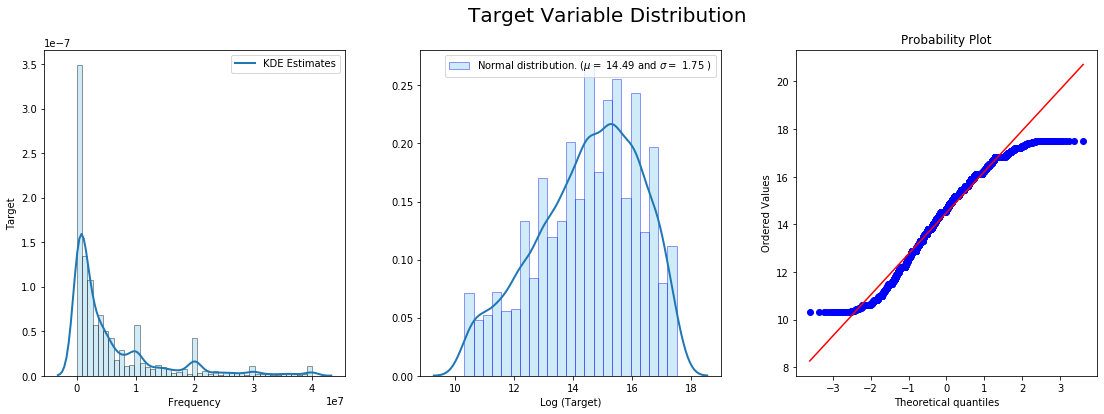

In [8]:
plt.subplots(1,3,figsize=(17,6))

plt.subplot(131)
from scipy import stats
from scipy.stats import norm
sns.distplot(train_df['target'],
            kde_kws={"lw":2,"label":"KDE Estimates"},
            hist_kws=dict(edgecolor="k", lw=1,color='skyblue'))
plt.ylabel('Target')
plt.xlabel('Frequency')

# New distribution log(target) plot
plt.subplot(132)
log_target = np.log(1+ train_df['target'])
sns.distplot(log_target,
             kde_kws={"lw":2},
             hist_kws=dict(edgecolor="b", lw=1,color='skyblue'))

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_target)
plt.legend(['Normal distribution. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.xlabel('Log (Target)')


# Probability Plot
plt.subplot(133)
stats.probplot(log_target, plot=plt)

# Subplots spacing
plt.suptitle("Target Variable Distribution",fontsize=20 )
plt.subplots_adjust(left=0.04, right=0.9, wspace=0.25, hspace=0.35)
plt.show()

- The target variable is right skewed distribution, so let's try to re-plot it with with log transform of the target. And we see that the statistical properties of the `Log(1+target)` distribution are much more amenable.

In [9]:
# log(1+target)
train_log_target = train_df[['target']]
train_log_target['target'] = np.log(1+train_df['target'].values)
train_log_target.describe()

,target
count,4459.000000
mean,14.490239
std,1.750947
min,10.308986
25%,13.304687
50%,14.630876
75%,15.894952
max,17.504390


### Constant Features
Generally when we get problems with many columns, there might be few columns with constant value in train set. So we can check that one as well.

In [10]:
constant_train = train_df.loc[:, (train_df == train_df.iloc[0]).all()].columns.tolist()
constant_test = test_df.loc[:, (test_df == test_df.iloc[0]).all()].columns.tolist()

print('Number of constant columns in the train set:', len(constant_train))
print('Number of constant columns in the test set:', len(constant_test))

Number of constant columns in the train set: 256
Number of constant columns in the test set: 0


So we have 256 columns with constant values in the train set. Probably it is a good idea to remove them from the training and the test set too as they won't be present in the training model. 

In [11]:
X_train = train_df.drop(["ID", "target"], axis=1)
y_train = np.log1p(train_df["target"].values)
X_test = test_df.drop(["ID"], axis=1)

# Check and remove constant columns
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0: 
        colsToRemove.append(col)
        
# Remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True)

# Remove constant columns in the test set
X_test.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `256` Constant Columns

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

So let's subset the colums that we'd use to just those that are not constant.

In [12]:
columns_to_use = test_df.columns.tolist()
del columns_to_use[0] # Remove 'ID'

columns_to_use = [x for x in columns_to_use if x not in constant_train] # Remove all 0 columns
len(columns_to_use)

4735

So we have the total of 4,735 columns to work with. 

### Duplicate Columns

In [13]:
# Check and remove duplicate columns
colsToRemove = []
colsScaned = []
dupList = {}

columns = X_train.columns

for i in range(len(columns)-1):
    v = X_train[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, X_train[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
X_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)

Removed `4` Duplicate Columns

{'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}


In [14]:
print("Train set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

Train set size: (4459, 4730)
Test set size: (49342, 4730)


As we have 4,730 features it would be very difficult to visualize and analyze all of them. So, we will try to "analyze only some of the top features".

## Correlation of features with target
Now let us find the correlation of the variables with target variable. It might be a good idea to use `spearman` correlation inplace of `pearson` since `spearman` is *computed on ranks* and so depicts monotonic relationships while `pearson` is on *true values* and *depicts linear relationships*.

There are thousands of variables and so plotting all of them will give us a cluttered plot. So let us take only those variables whose absolute `spearman` correlation coefficient is more than 0.1 just to reduce the number of variables.

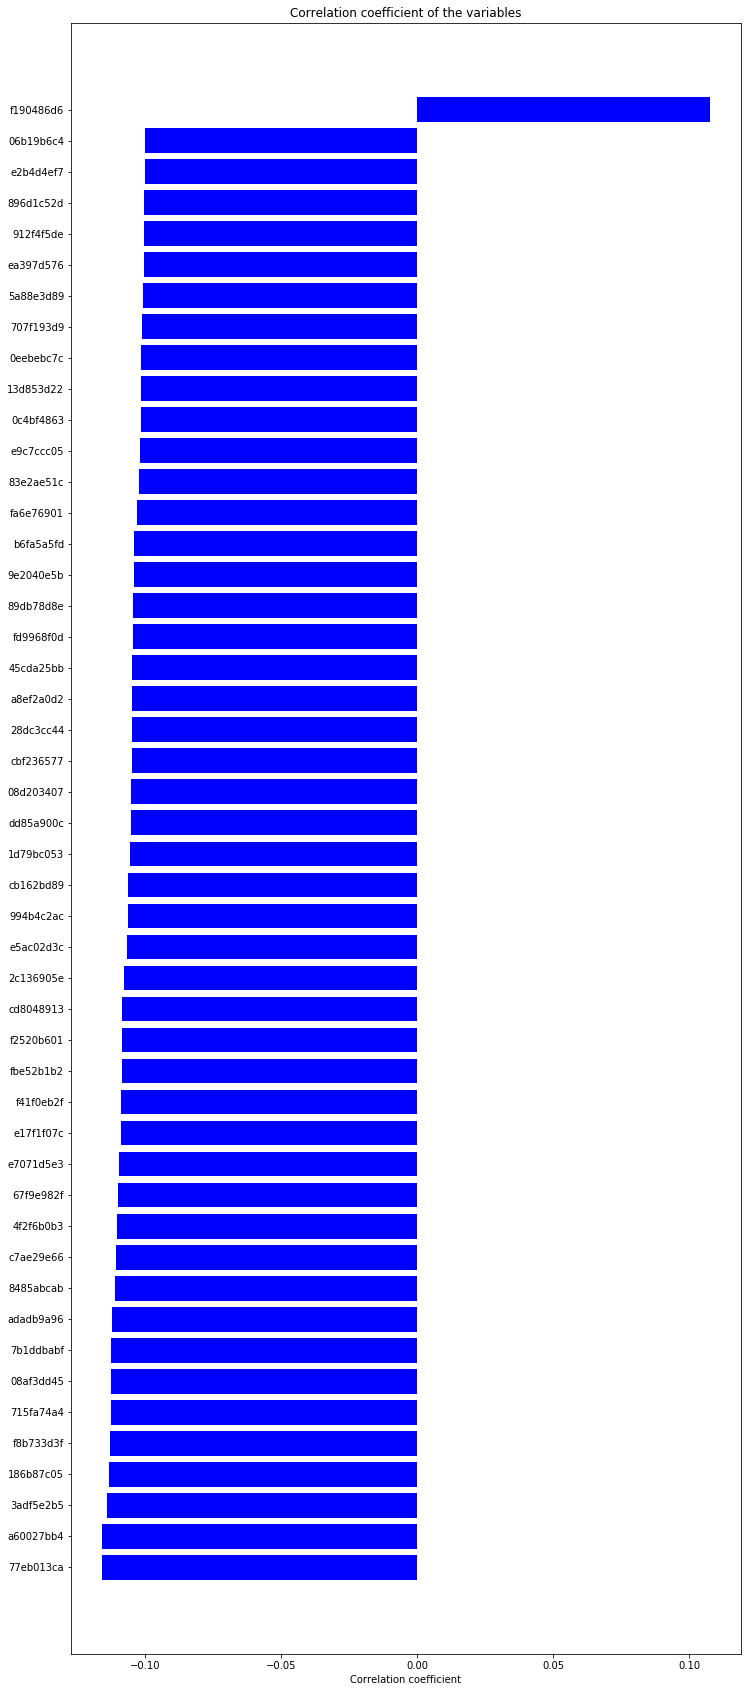

In [15]:
labels = []
values = []
for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

There are quite a few variables with absolute correlation greater than 0.1

## Correlation Heatmap
Now let us take these variables whose absolute value of correlation with the target is > 0.11 (just to reduce the number of features further) and do a correlation heat map.

This is just done to identify if there are any `strong monotonic relationships` between these important features. If the values are high, then probably we can choose to keep one of those variables in the model building process.

Text(0.5, 1, 'Important variables correlation map')

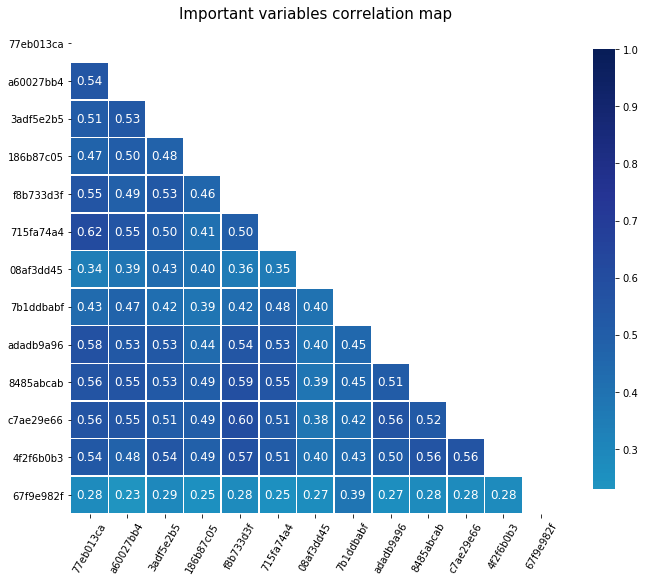

In [16]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat, annot=True, mask=mask, cmap='YlGnBu', vmax=1,center=0, fmt='.2f',
            square=True, linewidths=.5, annot_kws={'size': 12}, cbar_kws={'shrink': .9})
plt.xticks(rotation=60)
plt.title("Important variables correlation map", fontsize=15)

The above plots helped us in identifying the important individual variables which are correlated with target.



## Feature Importance
We will build two models to get the feature importances: 
- Extra trees 
- LightGBM. 



Our Evaluation metric for the competition is `RMSLE`. So let us use `log` transform of the target variable to build our models.

### Extra trees model

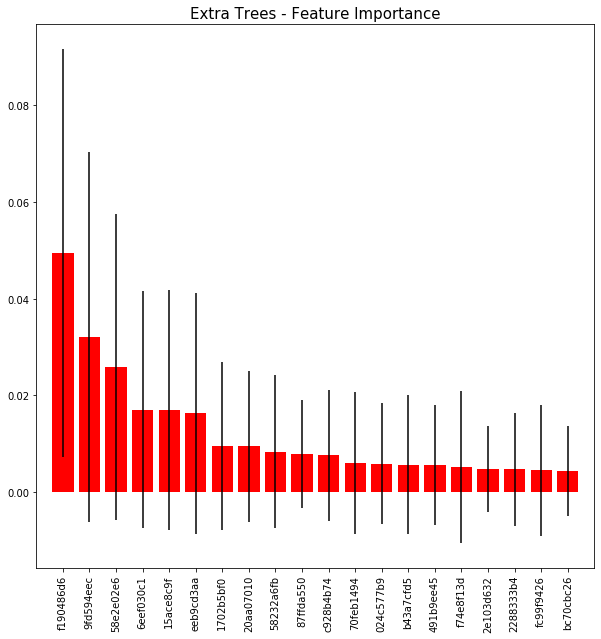

In [17]:
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

## Plot the importances
feat_names = X_train.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,10))
plt.title("Extra Trees - Feature Importance", fontsize=15)
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

### LightGBM
Now let us build a Light GBM model to get the feature importance. 

In [18]:
def run_lgb(X_train, y_train, val_X, val_y, X_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = X_train.loc[dev_index,:], X_train.loc[val_index,:]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

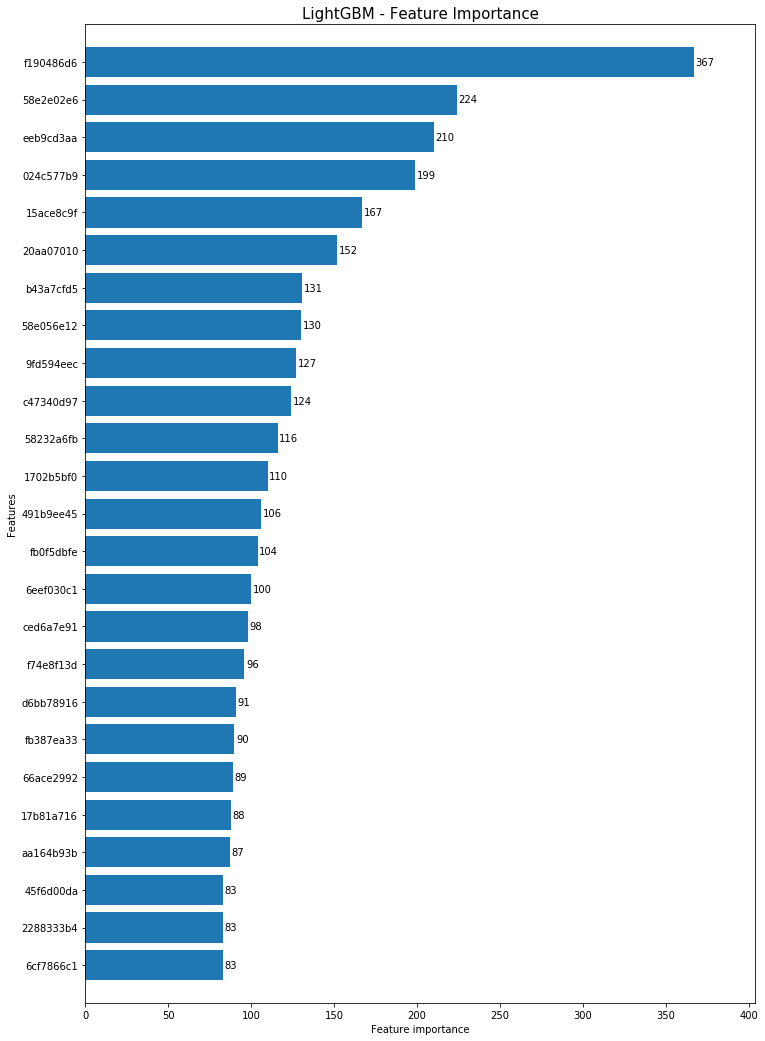

In [19]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### GradientBoostingRegressor

In [20]:
clf_gb = GradientBoostingRegressor(random_state = 42)
clf_gb.fit(X_train, y_train)
print(clf_gb)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


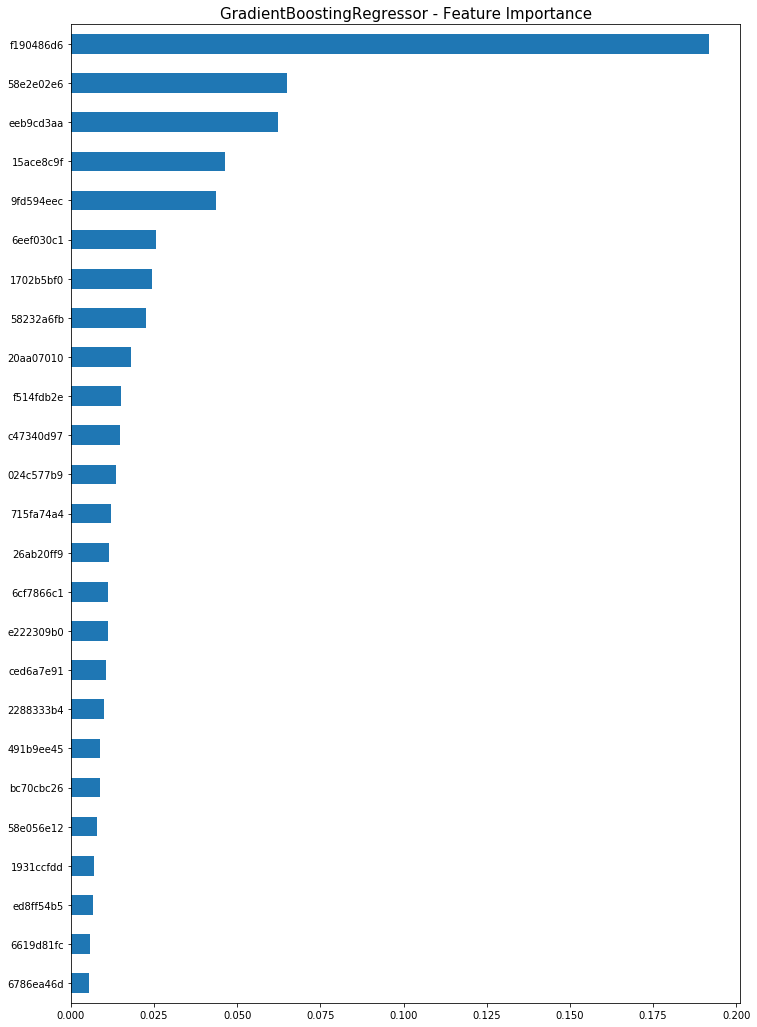

In [21]:
fig, ax = plt.subplots(figsize=(12,18))
feat_importances = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(25)
feat_importances.plot(kind='barh', ax=ax)
ax.grid(False)
plt.title("GradientBoostingRegressor - Feature Importance", fontsize=15)
plt.gca().invert_yaxis()
plt.show()

### RandomForestRegressor

In [22]:
clf_rf = RandomForestRegressor(random_state = 42)
clf_rf.fit(X_train, y_train)
print(clf_rf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


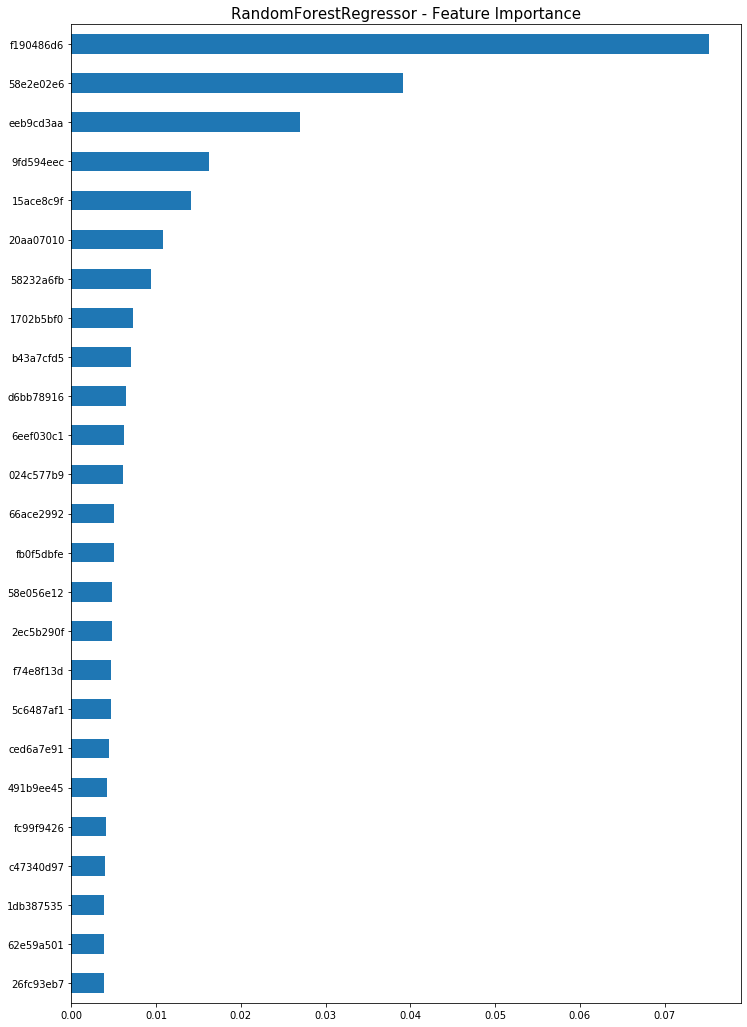

In [23]:
# RandomForestRegressor feature importance - top 25
fig, ax = plt.subplots(figsize=(12,18))
feat_importances_rf = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
feat_importances_rf = feat_importances_rf.nlargest(25)
feat_importances_rf.plot(kind='barh', ax=ax)
ax.grid(False)
plt.title("RandomForestRegressor - Feature Importance", fontsize=15)
plt.gca().invert_yaxis()
plt.show()